## Prepare Machine Learning Dataset

This notebook prepares and structures the Megaline dataset for machine learning modeling. It handles data cleaning, feature engineering, encoding, and train-validation-test splitting, ensuring consistent inputs for all ML experiments.

#### Objectives
*  Clean raw user data and handle missing or duplicate records.
*  Engineer meaningful features to improve model performance.
*  Split the dataset into training, validation, and test sets.
*  Save clean, ready-to-use datasets for downstream modeling.

In [1]:
!python load_megaline_data.py

Data successfully uploaded to MySQL!
MySQL connection closed.
(0, 40, 311.9, 83, 19915.4, 0)
(1, 85, 516.75, 56, 22697.0, 0)
(2, 77, 467.66, 86, 21060.4, 0)
(3, 106, 745.53, 81, 8437.39, 1)
(4, 66, 418.74, 1, 14502.8, 0)
(5, 58, 344.56, 21, 15823.4, 0)
(6, 57, 431.64, 20, 3738.9, 1)
(7, 15, 132.4, 6, 21911.6, 0)
(8, 7, 43.39, 3, 2538.67, 1)
(9, 90, 665.41, 38, 17358.6, 0)
/Users/tathianicol/Desktop/Analyst/Megaline Telecom/Notebook/load_megaline_data.py:95: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_sql = pd.read_sql(query, conn)


In [2]:
import pandas as pd
import mysql.connector
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, accuracy_score

In [3]:
# Set project root relative to the notebook's location
PROJECT_ROOT = Path.cwd().parents[0]  # go up one level
DATA_DIR = PROJECT_ROOT / "dataset"
SQL_DIR = PROJECT_ROOT / "sql"

import pandas as pd
df = pd.read_csv(DATA_DIR / "users_behavior.csv")

In [4]:
# Connect to MySQL and load data
conn = mysql.connector.connect(
    host="localhost",
    user="root",
    password="September97!",  # Your MySQL password
    database="megaline_db"
)

# Load the combined features view
df = pd.read_sql("SELECT * FROM megaline_features;", conn)
conn.close()

print("Data Preview:")
display(df.head())

Data Preview:


/var/folders/p3/43px2jb159dgb_cp9t6gw27h0000gn/T/ipykernel_63416/107899124.py:10: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql("SELECT * FROM megaline_features;", conn)


,user_id,calls,minutes,messages,mb_used,is_ultra,avg_calls,avg_minutes,avg_messages,avg_mb,total_revenue,avg_revenue
0,0,40,311.90,83,19915.40,0,40.0,311.899994,83.0,19915.419922,80.0,20.0
1,1,85,516.75,56,22697.00,0,85.0,516.750000,56.0,22696.960938,80.0,20.0
2,2,77,467.66,86,21060.40,0,77.0,467.660004,86.0,21060.449219,80.0,20.0
3,3,106,745.53,81,8437.39,1,106.0,745.530029,81.0,8437.389648,280.0,70.0
4,4,66,418.74,1,14502.80,0,66.0,418.739990,1.0,14502.750000,80.0,20.0


In [5]:
# Prepare ML Data

# Review columns
print("Available columns in the dataset:")
print(df.columns.tolist())

# Remove any columns that directly leak the target
# (e.g., 'is_ultra', and revenue columns if they directly encode the plan price)
leakage_columns = ['is_ultra', 'user_id', 'total_revenue', 'avg_revenue']
feature_columns = [col for col in df.columns if col not in leakage_columns]

# Create features (X) and target (y)

X = df[feature_columns]
y = df['is_ultra']

# Split into train/test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Scale numerical features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print(f"Training set shape: {X_train.shape}, Test set shape: {X_test.shape}")

Available columns in the dataset:
['user_id', 'calls', 'minutes', 'messages', 'mb_used', 'is_ultra', 'avg_calls', 'avg_minutes', 'avg_messages', 'avg_mb', 'total_revenue', 'avg_revenue']
Training set shape: (10284, 8), Test set shape: (2572, 8)


In [6]:
# Train Baseline Models
models = {
    'Decision Tree': DecisionTreeClassifier(max_depth=5, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42),
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42)
}

trained_models = {}
performance_summary = []

for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    trained_models[name] = model
    
    # Evaluate model
    report = classification_report(y_test, preds, output_dict=True, zero_division=0)
    performance_summary.append({
        "Model": name,
        "Accuracy": round(report['accuracy'], 2),
        "Precision (Ultra)": round(report['1']['precision'], 2),
        "Recall (Ultra)": round(report['1']['recall'], 2),
        "F1-score (Ultra)": round(report['1']['f1-score'], 2)
    })

performance_df = pd.DataFrame(performance_summary)
display(performance_df)

,Model,Accuracy,Precision (Ultra),Recall (Ultra),F1-score (Ultra)
0,Decision Tree,0.82,0.83,0.50,0.63
1,Random Forest,0.88,0.99,0.63,0.77
2,Logistic Regression,0.75,0.81,0.23,0.36


Three baseline models—Decision Tree, Random Forest, and Logistic Regression—were trained and evaluated. Random Forest achieved the highest overall accuracy (88%) and F1-score for Ultra subscribers (0.77), showing strong capability in distinguishing high value users. Decision Tree offered competitive performance with 82% accuracy, while Logistic Regression lagged behind (75% accuracy, F1-score 0.36), highlighting its limitations in handling class imbalance. These results indicate that tree based ensemble methods are better suited for this dataset.

### Model Evaluation
#### Feature Importance, Confusion Matrix, ROC Curve

Top 5 Features Influencing Ultra Plan Prediction:


mb_used        0.186815
avg_mb         0.178489
avg_minutes    0.124281
minutes        0.120737
avg_calls      0.101641
dtype: float64

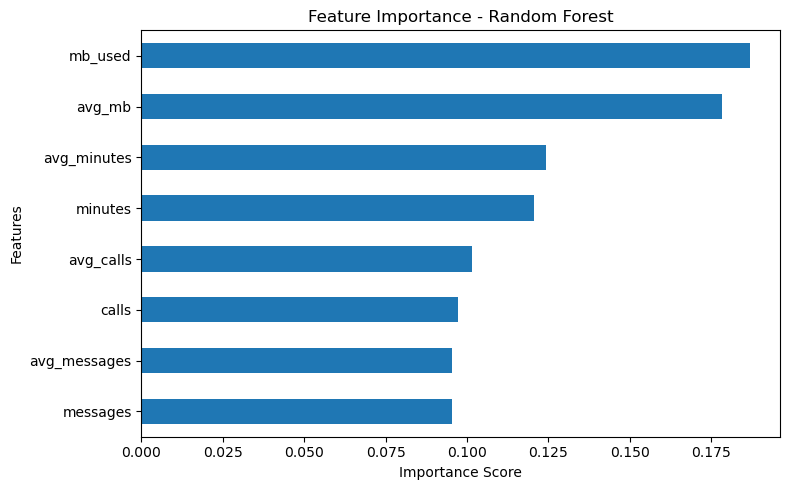

In [7]:
# Feature Importance for Random Forest
rf_model = trained_models['Random Forest']
importances = pd.Series(rf_model.feature_importances_, index=X.columns)

top_features = importances.sort_values(ascending=False).head(5)
print("Top 5 Features Influencing Ultra Plan Prediction:")
display(top_features)

plt.figure(figsize=(8,5))
importances.sort_values(ascending=True).plot(kind='barh', title="Feature Importance - Random Forest")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.tight_layout()
plt.show()

Feature importance analysis from the Random Forest model revealed that data usage (mb_used) and average monthly data usage (avg_mb) are the strongest predictors of Ultra plan adoption, followed by call related features like avg_minutes and minutes. Messaging activity had minimal influence. These insights suggest that high data consumption and consistent calling habits are key indicators of premium plan subscribers, which can guide targeted marketing strategies.

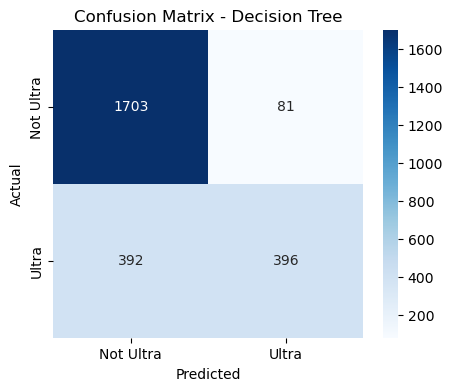

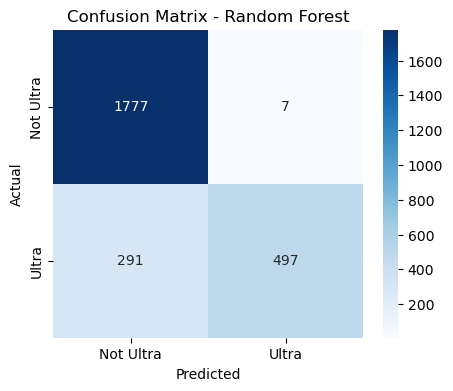

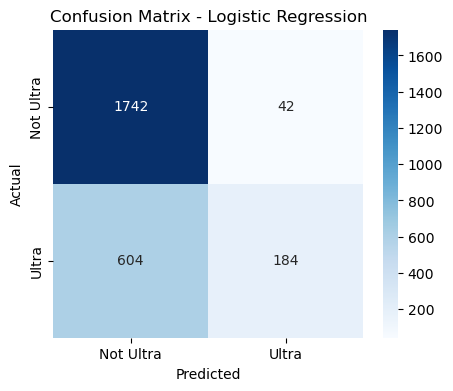

In [8]:
# Confusion Matrices for All Models
for name, model in trained_models.items():
    preds = model.predict(X_test)
    cm = confusion_matrix(y_test, preds)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["Not Ultra", "Ultra"], yticklabels=["Not Ultra", "Ultra"])
    plt.title(f"Confusion Matrix - {name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

The confusion matrices illustrate class level prediction performance. Random Forest outperformed other models in identifying Ultra subscribers, correctly predicting 497 Ultra users with fewer false negatives compared to Decision Tree and Logistic Regression. However, some Ultra subscribers were still misclassified as non-Ultra, reinforcing the impact of class imbalance. Logistic Regression notably struggled with Ultra detection, misclassifying a large portion of these customers, making it less suitable for this task.

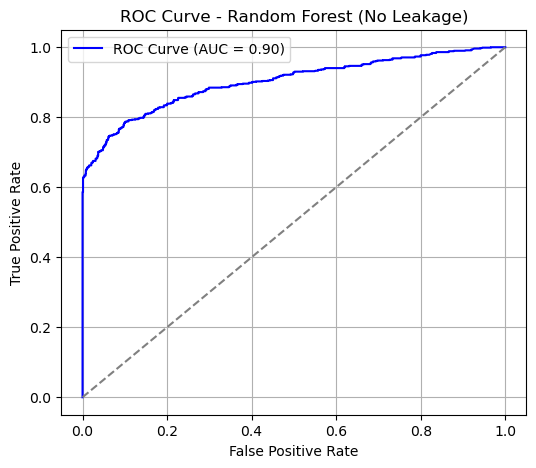

In [9]:
# ROC Curve for Random Forest (Best Model)
rf_model = trained_models['Random Forest']
rf_probs = rf_model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, rf_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})", color='blue')
plt.plot([0,1], [0,1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Random Forest (No Leakage)')
plt.legend()
plt.grid(True)
plt.show()

The ROC curve for the Random Forest model achieved an AUC of 0.90, indicating strong discriminative power between Ultra and non-Ultra users. The steep rise at the beginning of the curve shows that the model can effectively identify true positives while maintaining a low false positive rate, making it a reliable baseline model for future optimization.

#### Overall Findings & Next Steps

The Random Forest model emerged as the most effective baseline classifier, balancing precision (0.99) and recall (0.63) for Ultra users. However, recall remains moderate, meaning the model misses some high value customers. Class imbalance is a key challenge, and techniques such as SMOTE oversampling, class weighting, or advanced ensemble methods (e.g., XGBoost) should be explored to improve Ultra user recall.

Insights from feature importance highlight that data usage patterns are the strongest predictors of premium plan adoption, offering actionable guidance for retention campaigns and personalized offers. Future work should focus on feature engineering, hyperparameter tuning, and advanced ML pipelines to boost performance.